In [37]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')


try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the path to your .xml file in Google Drive
# Update this path to the actual path of your .xml file
file_path = '/content/drive/My Drive/rxx.xml'
# Load integrated scene
scene = load_scene(file_path) # Try also sionna.rt.scene.etoile
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
scene = load_scene(file_path)
scene.frequency = 5e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "H")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

tx = Transmitter("tx", [-15,3.5,2])
scene.add(tx)

width = 2 # Width [m]
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[-5,-2.5,2],
          orientation=[PI/2,0,0],
          num_rows=num_rows,
          num_cols=num_cols)

scene.add(ris)
tx.look_at([-5,-2.5,2])



source = tx.position
target = [0,2.5,2] # Target position

ris.phase_gradient_reflector(source, target)

(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)


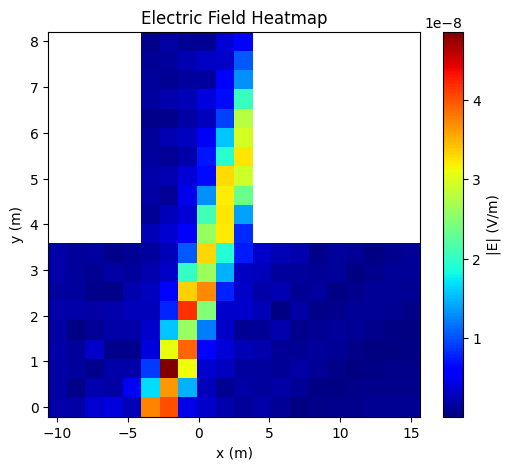

In [79]:
def compute_e_field_heatmap(scene, x_min, x_max, z_min, z_max, num_steps, batch_size, path_loss=False):
    # Create grid points in the x-y plane
    x = tf.cast(tf.linspace(x_min, x_max, num_steps), tf.float32)
    y = tf.cast(tf.linspace(z_min, z_max, num_steps), tf.float32)
    x_grid, y_grid = tf.meshgrid(x, y)
    x_flat = tf.reshape(x_grid, [-1])  # Flatten for computation
    y_flat = tf.reshape(y_grid, [-1])
    z_flat = tf.fill(tf.shape(x_flat), 1.5)  # Fixed z = 1.5

    # Combine into a single tensor for the x-y plane
    grid_points = tf.stack([x_flat, y_flat, z_flat], axis=1)

    # Ensure batch_size divides total number of points
    num_points = grid_points.shape[0]
    assert num_points % batch_size == 0,

    # Add batch_size receivers to the scene if not present
    if len(scene.receivers) == 0:
        for i in range(batch_size):
            scene.add(Receiver(f"rx-{i}", [0, 0, 0]))

    # Compute field strength iteratively for each batch
    e_field_values = []
    grid_batches = tf.reshape(grid_points, [-1, batch_size, 3])
    for batch in grid_batches:
        # Move receivers to current batch positions
        for i, pos in enumerate(batch):
            scene.get(f"rx-{i}").position = pos.numpy()

        # Compute paths and obtain channel impulse responses
        paths = scene.compute_paths(los=False, reflection=False, ris=True)
        a = tf.squeeze(paths.cir()[0])
        print(a.shape)

        if path_loss:
            e = 20*tf.math.log(tf.abs(a))/tf.math.log(10.)
        else:
            e = 4*PI/scene.wavelength*normalize(tx.position)[1]*tf.abs(a)

        e_field_values.append(e)

    # Combine results and reshape into the grid
    e_field = tf.concat(e_field_values, axis=0)
    e_field = tf.reshape(e_field, x_grid.shape)

    return x_grid, y_grid, e_field



# Example usage
x_min, x_max = -10, 15
y_min, y_max = 0, 8
num_steps = 20  # Higher resolution
batch_size = 5

x_grid, y_grid, e_field = compute_e_field_heatmap(scene, x_min, x_max, y_min, y_max, num_steps, batch_size)

# Visualization
plt.figure(figsize=(6, 5))
plt.pcolormesh(x_grid, y_grid, e_field, cmap='jet', shading='auto')
plt.colorbar(label="|E| (V/m)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Electric Field Heatmap")
plt.show()
